In [1]:
import pandas as pd
from Bio import SeqIO
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [20]:
#DATASET_PATH = os.path.join(os.getcwd(), "Cov dataset statewise fasta")
MODEL_PATH = os.path.join(os.getcwd(), "Model files")
#os.listdir(DATASET_PATH)

In [3]:
CSV_PATH = os.path.join(os.getcwd(), "Cov dataset statewise fasta", "data.csv")

df = pd.DataFrame(columns=["ID", "State/UT", "Sequence"])

In [29]:
for fasta in os.listdir(DATASET_PATH):
    if fasta.endswith(".fasta"):
        for seq_record in SeqIO.parse(DATASET_PATH + "/" + fasta, "fasta"):
            # save the record to dataframe
            df = pd.concat([df, pd.DataFrame([[seq_record.id, fasta[:-6], seq_record.seq]], columns=["ID", "State/UT", "Sequence"])], ignore_index=True)


df.to_csv(CSV_PATH, index=False)

In [2]:
df = pd.read_csv(r"D:\data.csv")

In [3]:
print("Total number of sequences: ", len(df))
df.head()

Total number of sequences:  70151


,ID,State/UT,Sequence
0,hCoV-19/India/MH-GA22/2020|EPI_ISL_508218|2020...,Maharashtra,ACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACG...
1,hCoV-19/India/MH-ACTREC-219/2020|EPI_ISL_69987...,Maharashtra,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
2,hCoV-19/India/MH-NCCS-NR2254/2020|EPI_ISL_4965...,Maharashtra,AAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAA...
3,hCoV-19/India/MH-ACTREC-119/2020|EPI_ISL_69977...,Maharashtra,ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACT...
4,hCoV-19/India/MH-ACTREC-087/2020|EPI_ISL_69974...,Maharashtra,CCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCT...


In [4]:
x = df["Sequence"]
y = df["State/UT"]

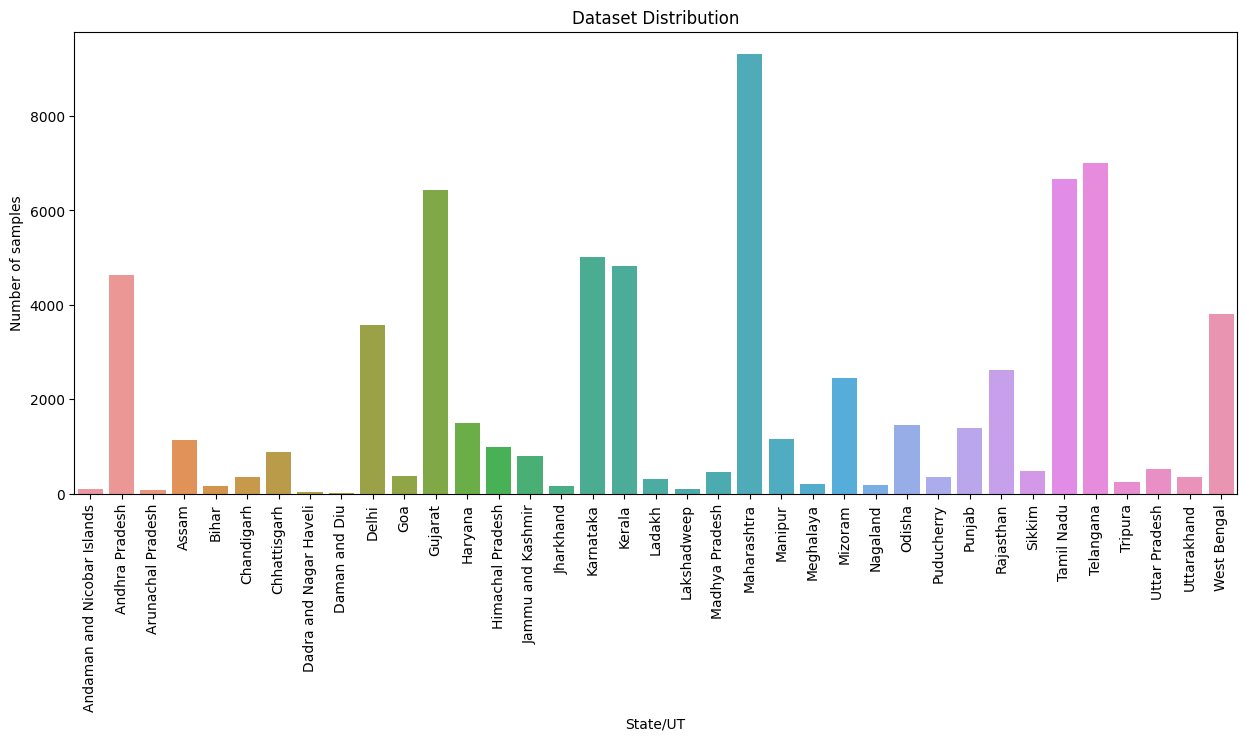

In [17]:

plt.figure(figsize=(15, 6))
sns.countplot(x="State/UT", data=df, order=sorted(df["State/UT"].unique()))
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.title("Dataset Distribution")
plt.show()


In [8]:
print(len(y.unique()))

37


## Train Test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## K-Merize

In [22]:
# convert sequence to k mer words of length n
def getKmers(sequence, size=3):
    seq = [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]
    n_str = "n"*size
    seq = [x if n_str not in x else "" for x in seq]
    seq = " ".join(seq)
    return seq


In [11]:
x_train = x_train.apply(lambda x: getKmers(x))
x_test = x_test.apply(lambda x: getKmers(x))

# convert it to an array of strings
x_train = np.array(x_train)
x_test = np.array(x_test)

## Count Vectorizer

In [18]:
# create a count vectorizer
cv = CountVectorizer(ngram_range=(2,2))

# fit and transform x_train
x_train = cv.fit_transform(x_train)
# transform x_test
x_test = cv.transform(x_test)

In [23]:
# save the count vectorizer
pickle.dump(cv, open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "wb"))

In [11]:
# load the count vectorizer
cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))

x_train = cv.fit_transform(x_train)
x_test = cv.transform(x_test)

x_train = x_train.toarray()
x_test = x_test.toarray()

In [21]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Deep Learning

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [13]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# save the label encoder
pickle.dump(le, open(MODEL_PATH + "\label_encoder_state_ut.pkl", "wb"))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [27]:
# oversample using SMOTE
sm = SMOTE(random_state=42)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

In [30]:
ros = RandomOverSampler(random_state=42)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [31]:
model = Sequential()
model.add(Dense(512, input_shape=(x_train_sm.shape[1],)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))
model.add(Dense(y_train_sm.shape[1], activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               1338880   
                                                                 
 batch_normalization_15 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 512)               0         
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_16 (Bat  (None, 256)              1024      
 chNormalization)                                     

In [32]:
model.fit(x_train_ros, y_train_ros, epochs=50, batch_size=128, validation_data=(x_test, y_test))

model.save(MODEL_PATH + "\state_ut_model.h5")

Epoch 1/50
2153/2153 [==============================] - 47s 21ms/step - loss: 1.3542 - accuracy: 0.6037 - val_loss: 77.4001 - val_accuracy: 0.0925
Epoch 2/50
2153/2153 [==============================] - 47s 22ms/step - loss: 0.7667 - accuracy: 0.7626 - val_loss: 59.6517 - val_accuracy: 0.0176
Epoch 3/50
 188/2153 [=>............................] - ETA: 38s - loss: 0.6408 - accuracy: 0.7973

KeyboardInterrupt: 

## Random Forest

In [46]:
# create a random forest classifier
rf_classifier = RandomForestClassifier()
# fit the classifier to x_train and y_train
rf_classifier.fit(x_train_sm, y_train_)
# predict the labels of x_test
y_pred = rf_classifier.predict(x_test)
# print the accuracy score
print("Accuracy:", accuracy_score(y_test_, y_pred))


Accuracy: 0.7442805217019457


In [41]:
# revert one hot encoding
y_train_ = np.argmax(y_train_ros, axis=1)

# revert label encoding
y_train_ = le.inverse_transform(y_train_)

## decision tree

In [42]:
dt = DecisionTreeClassifier()
dt.fit(x_train_ros, y_train_)
y_pred = dt.predict(x_test)



ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [44]:
# print the accuracy score
print("Accuracy score: ", accuracy_score(y_test_, y_pred))

# save the model
#pickle.dump(dt, open(MODEL_PATH + "\decision_tree_state_ut.pkl", "wb"))

Accuracy score:  0.46739362839426984


In [14]:
# save the model to a pickle file
pickle.dump(rf_classifier, open(MODEL_PATH + r"\random_forest_classifier_state.pkl", "wb"))

NameError: name 'rf_classifier' is not defined

In [31]:
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(sklearn_accuracy*100))


Accuracy: 73.85%


In [33]:
conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
classification_report(y_test, y_pred)

## Balance the Dataset

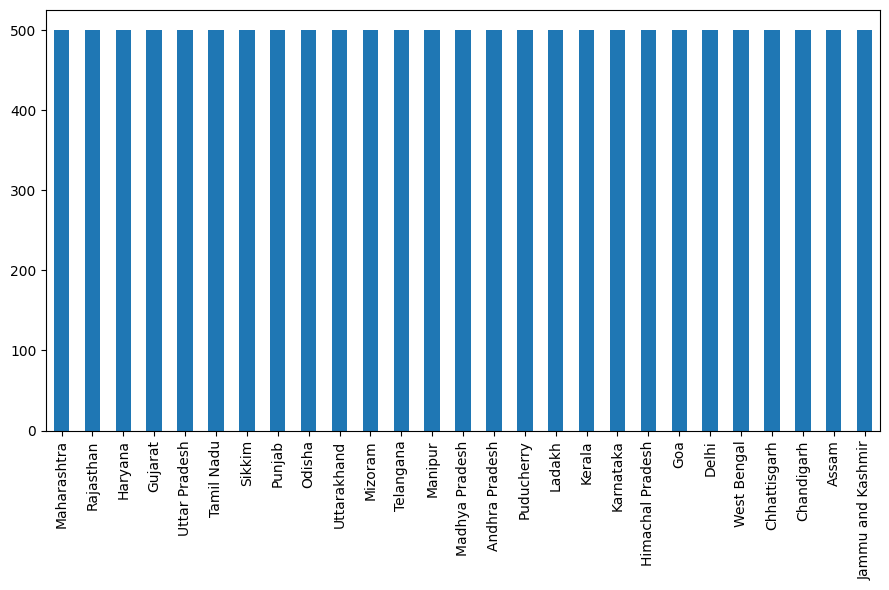

In [69]:

state_ut_list = list(df["State/UT"].unique())

df1 = pd.DataFrame(columns=["ID", "State/UT", "Sequence"])
for state_ut in state_ut_list:
    if len(df[df["State/UT"] == state_ut]) < 500 and len(df[df["State/UT"] == state_ut]) > 250:
        df1 = pd.concat([df1, df[df["State/UT"] == state_ut]], ignore_index=True)
    elif len(df[df["State/UT"] == state_ut]) > 500:
        indexes = np.random.choice(df[df["State/UT"] == state_ut].index, 500, replace=False)
        df1 = pd.concat([df1, df.iloc[indexes]], ignore_index=True)
    
# 

x = df1["Sequence"]
y = df1["State/UT"]

ros = RandomOverSampler(random_state=42)
x, y = ros.fit_resample(np.array(x).reshape(-1, 1), y)

plt.figure(figsize=(9, 6))
y.value_counts().plot(kind="bar")
plt.tight_layout()
plt.show()


In [70]:
x = pd.DataFrame(x, columns=["Sequence"])
y = pd.DataFrame(y, columns=["State/UT"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.apply(lambda x: getKmers(x["Sequence"]), axis=1)
x_test = x_test.apply(lambda x: getKmers(x["Sequence"]), axis=1)

# convert it to an array of strings
x_train = np.array(x_train)
x_test = np.array(x_test)

# create a count vectorizer
cv = CountVectorizer(ngram_range=(2,2))

# fit and transform x_train
x_train = cv.fit_transform(x_train)
# transform x_test
x_test = cv.transform(x_test)

# save the count vectorizer
pickle.dump(cv, open(MODEL_PATH + "\count_vectorizer_state_ut_balanced.pkl", "wb"))

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# create a random forest classifier# create a random forest classifier
rf_classifier = RandomForestClassifier()
# fit the classifier to x_train and y_train
rf_classifier.fit(x_train, y_train)
# predict the labels of x_test
y_pred = rf_classifier.predict(x_test)


# save the model to a pickle file
pickle.dump(rf_classifier, open(MODEL_PATH + r"\random_forest_classifier_state_balanced.pkl", "wb"))

In [71]:
sklearn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(sklearn_accuracy*100))

Accuracy: 62.11%


In [18]:
x = df["Sequence"]
y = df["State/UT"]

# select 20000 random samples
indexes = np.random.choice(df.index, 2000, replace=False)

x = x.iloc[indexes]
y = y.iloc[indexes]

# load the count vectorizer
cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))

x = x.apply(lambda x: getKmers(x))
x = np.array(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# fit and transform x_train
x_train = cv.transform(x_train)
# transform x_test
x_test = cv.transform(x_test)

NameError: name 'MODEL_PATH' is not defined

In [130]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [140]:
ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

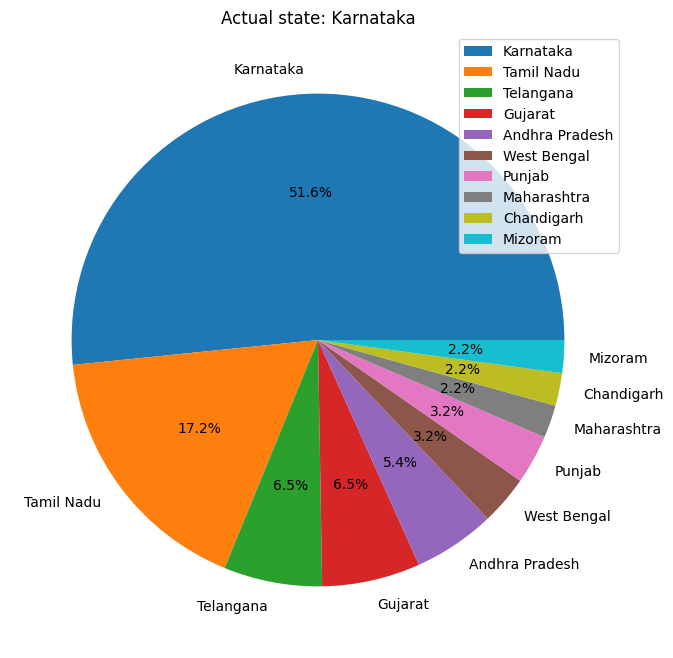

In [197]:
index = np.random.choice(df.index)
xt = df.iloc[index]["Sequence"]
yt = df.iloc[index]["State/UT"]

xt = getKmers(xt)

cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))
xt = cv.transform([xt])

xt = xt.toarray()

rf = pickle.load(open(MODEL_PATH + r"\random_forest_classifier_state.pkl", "rb"))

# predict the top 10 states
top_5 = rf.predict_proba(xt)[0].argsort()[-10:][::-1]

# get the top 10 states
top_5_states = [rf.classes_[i] for i in top_5]

# get the top 10 probabilities
top_5_prob = [rf.predict_proba(xt)[0][i] for i in top_5]

# get the actual state
actual_state = yt

# display the results in a pie chart
plt.figure(figsize=(15, 8))
plt.pie(top_5_prob, labels=top_5_states, autopct="%1.1f%%")
plt.title("Actual state: " + actual_state)
# legend showing states
plt.legend(top_5_states)
plt.show()

In [25]:
x = df["Sequence"]
y = df["State/UT"]

# select 10000 random samples
indexes = np.random.choice(df.index, 20000, replace=False)

x = x.iloc[indexes]
y = y.iloc[indexes]

# load the count vectorizer
cv = pickle.load(open(MODEL_PATH + "\count_vectorizer_state_ut.pkl", "rb"))

x = x.apply(lambda x: getKmers(x))
x = np.array(x)

# transform x
x = cv.transform(x)

x = x.toarray()

# load the random forest classifier
rf = pickle.load(open(MODEL_PATH + r"\random_forest_classifier_state.pkl", "rb"))


In [26]:

# get the unique states
states = df["State/UT"].unique()

statewise_accuracy = {state: 0 for state in states}

for i in range(len(x)):
    # get the actual state
    actual = y.iloc[i]
    pred = rf.predict([x[i]])[0]
    statewise_accuracy[actual] += 1 if actual == pred else 0

for state in statewise_accuracy:
    statewise_accuracy[state] /= len(y[y == state])

In [29]:
# final accuracy
final_accuracy = np.sum([statewise_accuracy[state]*len(y[y == state]) for state in statewise_accuracy])
final_accuracy /= len(y)
final_accuracy *= 100
final_accuracy = round(final_accuracy, 2)

In [62]:
#acc_dict = {"State/UT": list(statewise_accuracy.keys()), "Accuracy": list(statewise_accuracy.values())}
#acc_dict["Accuracy"] = [round(acc*100, 2) for acc in acc_dict["Accuracy"]]
#
##sort alphabetically
##acc_dict["State/UT"] = [x for _, x in sorted(zip(acc_dict["Accuracy"], acc_dict["State/UT"]), reverse=True)]
## print statewise accuracy
#for state in acc_dict:
#    print(state, acc_dict[state])

State/UT ['Maharashtra', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'West Bengal', 'Daman and Diu', 'Delhi', 'Goa', 'Meghalaya', 'Himachal Pradesh', 'Nagaland', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Puducherry', 'Madhya Pradesh', 'Rajasthan', 'Manipur', 'Telangana', 'Mizoram', 'Uttarakhand', 'Odisha', 'Punjab', 'Sikkim', 'Tamil Nadu', 'Tripura', 'Uttar Pradesh', 'Andaman and Nicobar Islands', 'Dadra and Nagar Haveli', 'Gujarat', 'Haryana', 'Jammu and Kashmir', 'Lakshadweep']
Accuracy [97.52, 96.11, 84.21, 90.71, 83.64, 86.36, 91.56, 94.74, 66.67, 91.55, 94.87, 89.09, 84.27, 92.0, 76.6, 92.9, 98.68, 91.36, 79.81, 86.89, 96.23, 85.36, 96.0, 97.68, 87.25, 93.22, 91.83, 88.89, 96.95, 85.0, 89.39, 69.7, 63.64, 96.91, 94.9, 89.7, 89.66]


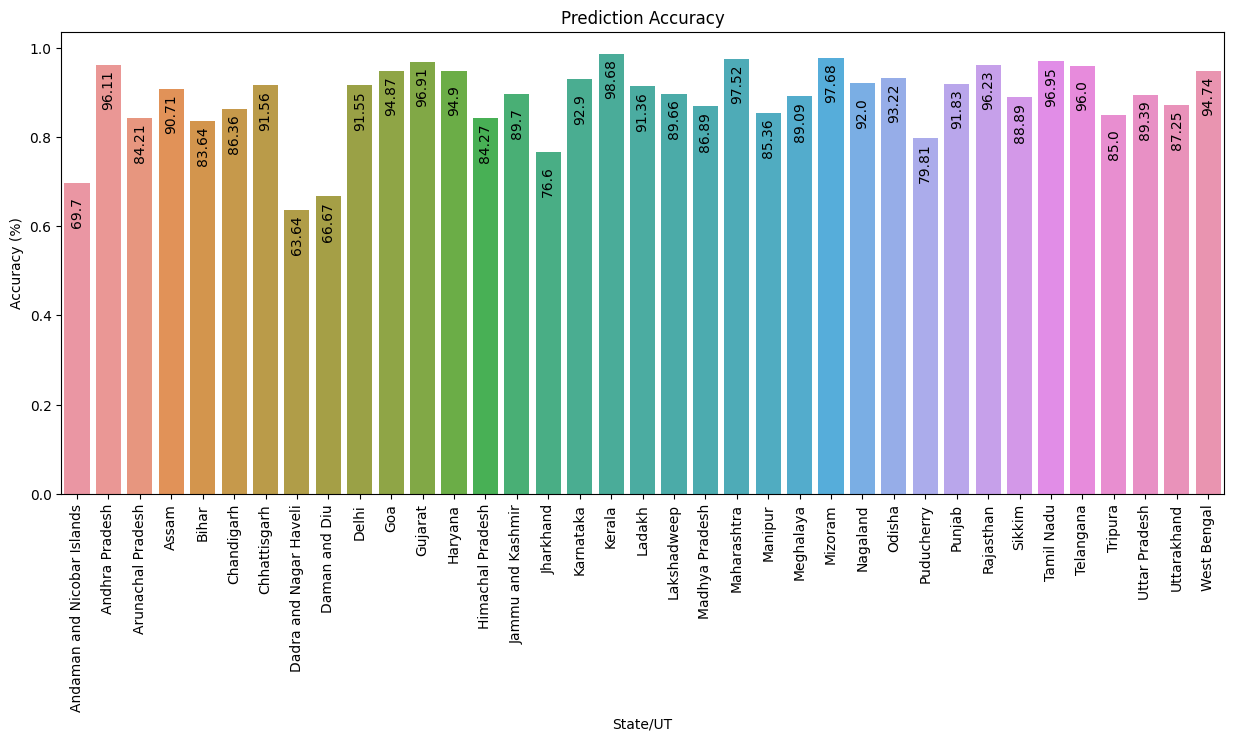

In [88]:
# display the results in a bar graph alphabetically
plt.figure(figsize=(15, 6))
sns.barplot(x=list(statewise_accuracy.keys()), y=list(statewise_accuracy.values()), order=sorted(statewise_accuracy.keys()))
# sort accuracy alphabetically
index_sorted = np.argsort(list(statewise_accuracy.keys()))
sorted_acc = np.array(list(statewise_accuracy.values()))[index_sorted]
for i, acc in enumerate(sorted_acc):
    plt.text(i, acc-0.1, str(round(acc*100, 2)), ha="center", va="bottom", rotation=90)
plt.xticks(rotation=90)
plt.title("Prediction Accuracy")
plt.xlabel("State/UT")
plt.ylabel("Accuracy (%)")
plt.show()

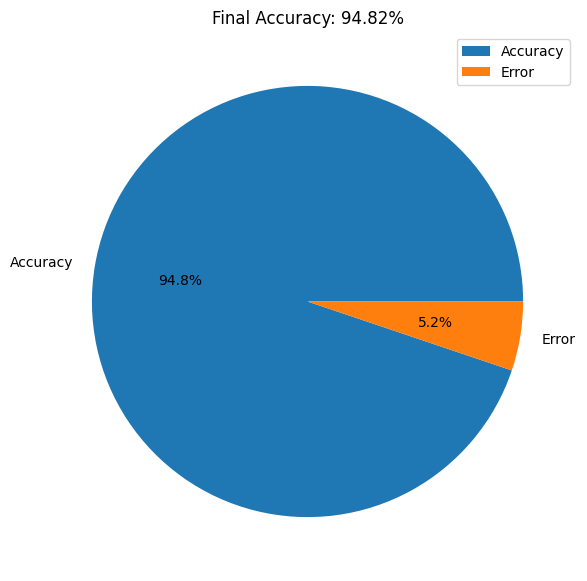

In [89]:
# doughnut chart of final accuracy
plt.figure(figsize=(7, 7))
plt.pie([final_accuracy, 100-final_accuracy], labels=["Accuracy", "Error"], autopct="%1.1f%%")
plt.title("Final Accuracy: " + str(final_accuracy) + "%")
plt.legend(["Accuracy", "Error"])
plt.show()

In [44]:
import Bio
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices
import cv2

In [ ]:
# align two sequences
seq1 = np.random.choice(df["Sequence"])
seq2 = np.random.choice(df["Sequence"])

seq1 = Bio.Seq.Seq(seq1)
seq2 = Bio.Seq.Seq(seq2)

aligner = PairwiseAligner()
aligner.mode = "global"
#aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

alignments = aligner.align(seq1, seq2)

# get the best alignment
best_alignment = alignments[0]